### 새로운 특성을 선택하는 방법

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
import numpy as np 

In [2]:
cancer=load_breast_cancer()
print(cancer.data.shape)

(569, 30)


* 실제로 30개 피쳐, 70개의 피쳐 생성
* 40개는 노이즈.
* 실제로 SelectPercentile을 썼을 때, 노이즈 변수가 선택되지 않는지 확인.

In [3]:
rng=np.random.RandomState(42)
noise=rng.normal(size=(len(cancer.data),40))
noise.shape

(569, 40)

In [4]:
X_w_noise=np.hstack([cancer.data,noise])
X_w_noise.shape

(569, 70)

In [5]:
# 모델을 선택, 학습 및 적용
X=X_w_noise # 입력
y=cancer.target # 출력

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=0, test_size=.5)

In [6]:
# 객체 중 절반인 35개만 선택.
select=SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

# 실제로 선택되는지 확인
X_train_sel=select.transform(X_train)

print('X_train.shape : ',X_train.shape)
print('X_train_sel.shape : ',X_train_sel.shape)

X_train.shape :  (284, 70)
X_train_sel.shape :  (284, 35)


### 실습 
* 객체 60개 생성하고, 이 중 30개만 선택

In [7]:
# 고정된 난수 발생
rng_p=np.random.RandomState(42)
noise_p=rng_p.normal(size=(len(cancer.data),30))

X_p_noise=np.hstack([cancer.data, noise_p])
print( X_p_noise.shape )

(569, 60)


In [8]:
X = X_p_noise  # 입력
y = cancer.target # 출력

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=0, test_size=0.5)

# 50%를 뽑는 것을 학습
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

SelectPercentile(percentile=50)

### 시각화

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False  True False False False
 False False False  True False False False False  True False  True False]


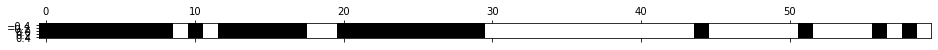

In [10]:
import matplotlib.pyplot as plt 
mask=select.get_support()
print(mask)
plt.matshow(mask.reshape(1,-1), cmap='gray_r')

In [13]:
from sklearn.linear_model import LogisticRegression

print(X_train.shape, X_test.shape)

# 원본 
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("스코어 : {:.3f}".format(lr.score(X_test, y_test)))

X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)
print(X_train_sel.shape, X_test_sel.shape)

# 노이즈가 추가된 데이터
lr.fit(X_train_sel, y_train)
print("스코어 : {:.3f}".format(lr.score(X_test_sel, y_test)))

(284, 60) (285, 60)
스코어 : 0.923
(284, 30) (285, 30)
스코어 : 0.923


In [14]:
X = cancer.data # 입력
y = cancer.target # 출력

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0,
                                                    test_size=0.5)

# 원본 
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("스코어 : {:.3f}".format(lr.score(X_test, y_test)))

스코어 : 0.954


### 모델 기반 선택


In [17]:
X=X_p_noise # 입력
y=cancer.target # 출력

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=.5)

print(X_train.shape, y_train.shape)

(284, 60) (284,)


In [18]:
from sklearn.feature_selection import SelectFromModel 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, 
                               random_state = 42)

select = SelectFromModel(model, threshold='median')
select.fit(X_train, y_train)
X_train_model_sel = select.transform(X_train)

print("X_train.shape :" , X_train.shape)
print("X_train_model.shape :", X_train_model_sel.shape)

X_train.shape : (284, 60)
X_train_model.shape : (284, 30)


In [19]:
# 테스트 데이터 변환
X_test_l1 = select.transform(X_test)

# lr=LogisticRegression
lr.fit(X_train, y_train)
print('전체 특성 사용 : {:.3f}'.format(lr.score(X_test, y_test)))

전체 특성 사용 : 0.923


### 반복적 특성 선택
* 특성의 수가 각기 다른 일련의 모델 생성
    * 특성을 하나도 선택하지 않고 종료조건까지 하나씩 추가
    * 모든 특성을 가지고 시작해 종료조건까지 하나씩 제거
* 이전 방법들보다 계산 비용이 많이 듬.

In [20]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
            n_features_to_select=40)

select.fit(X_train, y_train)


RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=40)

Text(0.5, 0, '특성 번호')

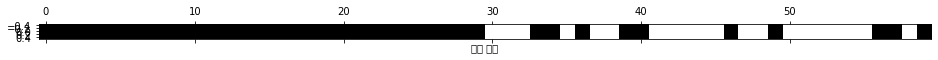

In [21]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("특성 번호")


In [23]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("테스트 점수 : {:.3f}".format(score))

테스트 점수 : 0.940
